# 1. Data Preparation

## 1.1 Import libraries

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer # for TFIDF vectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%config InlineBackend.figure_format = 'svg' # for better quality images

## 1.2 Load dataset

In [2]:
init_df = pd.read_csv('../../datasets/tokenized/blog_authorship_tokenized.csv', encoding='utf8',
                      usecols=['text', 'tokenized', 'gender'])

sample_df = pd.read_csv('../../datasets/tokenized/blog_authorship_tokenized_sample.csv', encoding='utf8')
sample_df = sample_df.drop_duplicates(subset=['text'])

df = pd.merge(sample_df, init_df[['text', 'gender']], on='text', how='inner')
df.head(10)

,text,age_group,n_words,tokenized,gender
0,Great Find To my surprise tonight I found an a...,<35,46,great find to my surprise tonight i found an a...,male
1,"Okay, okay, I admit, it is a very obscure quot...",<35,47,"okay , okay , i admit , it is a very obscure q...",male
2,"OK, after many hassles, I finally uploaded my ...",<35,14,"ok , after many hassles , i finally uploaded m...",male
3,"I'm gonna start by saying, what a big freakin'...",<35,565,"i 'm gon na start by saying , what a big freak...",female
4,Heard from Mark today. He's in Washington stat...,<35,273,heard from mark today . he 's in washington st...,male
5,A blog runs through it I've taken certain leng...,<35,832,a blog runs through it i 've taken certain len...,male
6,BBC NEWS | Americas | Rogue mountain lion kil...,<35,11,bbc news | americas | rogue mountain lion ki...,male
7,"Hi all, Looks like people have stopped bloggin...",<35,114,"hi all , looks like people have stopped bloggi...",male
8,"Hi all, Looks like people have stopped bloggin...",<35,114,"hi all , looks like people have stopped bloggi...",male
9,"Hi all, Looks like people have stopped bloggin...",<35,114,"hi all , looks like people have stopped bloggi...",male


In [3]:
df['text'].duplicated().sum()

2747

In [4]:
init_df['text'].duplicated().sum()

58508

In [5]:
sample_df['text'].duplicated().sum()

0

In [6]:
print(df.shape)
df = df.drop_duplicates(subset=['text'])
print(df.shape)

(8993, 5)
(6246, 5)


## 1.3 Feature engineering

In [7]:
vectorizer = TfidfVectorizer(
    min_df=3,
    ngram_range=(1,3),
    sublinear_tf=True # change TF calculation method
).fit(df['tokenized'])

print('Number of tokens:', len(vectorizer.get_feature_names_out()))

Number of tokens: 107262


In [8]:
# Prepare the predictor and target variables
X = vectorizer.transform(df['tokenized'])
y = df['gender'].tolist()

X.shape[0] == len(y)

# testing predictors
# submit_x = vectorizer.transform(submit_raw.tweets)

True

# Part 2 : Exploratory Data Analysis

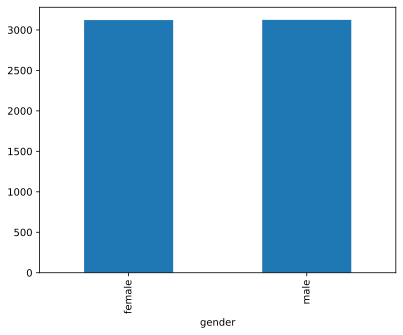

In [9]:
# plot train label distribution
df.groupby('gender')['tokenized'].count().plot.bar(ylim=0)
plt.show()

The target variable has a balance distribution on each class, so no need to do over or under sampling method to make it balance. 

# Part 3: Model Development
## 3.1 Auxilliary Functions for Model Development

In [10]:
# Cross validation function 
def model_CV(x_train, y_train, model, CV=10):
    name = model.__class__.__name__

    kfold = KFold(n_splits=CV, random_state=97, shuffle=True)

    cv_results = cross_val_score(model, x_train, y_train, cv=CV, scoring='f1_macro', verbose=10, n_jobs=-1)
    f1 = round(cv_results.mean(), 5) # take the mean of all folds' score
    std = round(cv_results.std(), 5) # take the std of all folds' score
    print(f"{name}: {f1} ({std})")

    return (f1, std)

In [11]:
# Grid search function
def grid_hyper(model, train_x, train_y, param_grid, CV=10):
    name = model.__class__.__name__

    model_grid = GridSearchCV(model, param_grid, cv=CV, scoring='f1_macro', verbose=10, n_jobs=-1)
    model_grid.fit(train_x, train_y)

    score = round(model_grid.best_score_, 5)
    std = round(model_grid.cv_results_['std_test_score'][model_grid.best_index_],5)
    print(f"{name}: {score} ({std})")

    return (model_grid, score, std)

## 3.2 Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((4996, 107262), (1250, 107262), 4996, 1250)

## 3.3 Model Development

In [13]:
# put all base model and its tuning parameter in one dataframe
models = {
    'name':[
        'LR',
        'SVM',
    ],
    'base':[
        LogisticRegression(max_iter=5000),
        SVC(max_iter=5000),
    ],
    'param':[
        {
            "C": [10**i for i in range(-2,3)],
            "solver": ['liblinear', 'saga'],
        },
        {
            "C": [10**i for i in range(-2,3)],
            "kernel": ['linear', 'rbf']
        },
    ]
}

models = pd.DataFrame(models)
models.head()

,name,base,param
0,LR,LogisticRegression(max_iter=5000),"{'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lib..."
1,SVM,SVC(max_iter=5000),"{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['lin..."


### Cross validate each base model

In [14]:
# using pandas dataframe apply method, try all base models
models['cv_score'] = models.apply(lambda model: model_CV(X_train, y_train, model['base']), axis=1)
models.head()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    9.8s remaining:   23.1s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   10.0s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   10.5s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.8s finished


LogisticRegression: 0.64376 (0.02133)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  2.3min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  2.3min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.4min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.6min finished


SVC: 0.64655 (0.02181)


,name,base,param,cv_score
0,LR,LogisticRegression(max_iter=5000),"{'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lib...","(0.64376, 0.02133)"
1,SVM,SVC(max_iter=5000),"{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['lin...","(0.64655, 0.02181)"


### Tuning hyperparameters

In [15]:
grid_result = models.apply(lambda model: grid_hyper(model['base'], X_train, y_train, model['param']), axis=1)
grid_result.head()

Fitting 10 folds for each of 10 candidates, totalling 100 fits
LogisticRegression: 0.64376 (0.02102)
Fitting 10 folds for each of 10 candidates, totalling 100 fits
SVC: 0.64735 (0.02015)


c:\github\clips-internship\Stylene v2\venv\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0    (GridSearchCV(cv=10, estimator=LogisticRegress...
1    (GridSearchCV(cv=10, estimator=SVC(max_iter=50...
dtype: object

In [16]:
# save grid score and grid model to models dictionary
models['grid_score'] = grid_result.apply(lambda grid: (grid[1], grid[2]))
models['grid_best_params'] = grid_result.apply(lambda grid: grid[0].best_params_)
models

,name,base,param,cv_score,grid_score,grid_best_params
0,LR,LogisticRegression(max_iter=5000),"{'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lib...","(0.64376, 0.02133)","(0.64376, 0.02102)","{'C': 1, 'solver': 'saga'}"
1,SVM,SVC(max_iter=5000),"{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['lin...","(0.64655, 0.02181)","(0.64735, 0.02015)","{'C': 10, 'kernel': 'rbf'}"


LSVM is still the best model out of two linear models. Changing hyperparameters using grid search successfully increases LR and LSVM CV score and also makes their performance less varied.

### Check All Tuned Model using Validation Dataset

In [17]:
(models
    .apply(lambda model: model['base'].set_params(**model['grid_best_params']), axis=1)
    .apply(lambda model: model.fit(X_train, y_train))
    .apply(lambda model: model.score(X_test, y_test))
)

c:\github\clips-internship\Stylene v2\venv\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0    0.6432
1    0.6496
dtype: float64

On predicting validation dataset, all models show an increasing performance with perceptron as the best performing model. All those increases are still in their 95% confident estimation range (1.96 * std) which means that all models can generalized well on unseen data and we can expect to get a similar accoracy score when we predicting test dataset.

### Fit Final Models with all train dataset

In [18]:
models['final_model'] = (models
                            .apply(lambda model: model['base'].set_params(**model['grid_best_params']), axis=1)
                            .apply(lambda model: model.fit(X_train, y_train))
                        )

c:\github\clips-internship\Stylene v2\venv\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Calculate All Final Models' Accuracy

In [19]:
models['final_score'] = models['final_model'].apply(lambda model: model.score(X_test, y_test))
models

,name,base,param,cv_score,grid_score,grid_best_params,final_model,final_score
0,LR,"LogisticRegression(C=1, max_iter=5000, solver=...","{'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lib...","(0.64376, 0.02133)","(0.64376, 0.02102)","{'C': 1, 'solver': 'saga'}","LogisticRegression(C=1, max_iter=5000, solver=...",0.6432
1,SVM,"SVC(C=10, max_iter=5000)","{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['lin...","(0.64655, 0.02181)","(0.64735, 0.02015)","{'C': 10, 'kernel': 'rbf'}","SVC(C=10, max_iter=5000)",0.6496


We get a similar level of accuracy score. All models' performance is still inside their confident interval range with SVM model as the best performing.